In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option('display.max_columns', 100)

dfMain = pd.DataFrame.from_csv('data.csv')
print(dfMain.shape)
print(dfMain['combined_shot_type'].unique())
# dfMain['game_id'].plot()
# dfMain['game_event_id'].plot()
display(dfMain.head())

(30697, 24)
['Jump Shot' 'Dunk' 'Layup' 'Tip Shot' 'Hook Shot' 'Bank Shot']


,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
action_type,,,,,,,,,,,,,,,,,,,,,,,,
Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [2]:
# Reset index
dfMain = dfMain.reset_index(drop=True)

In [3]:
# Separate training/submit data
training_data = dfMain[~dfMain['shot_made_flag'].isnull()]
submit_data = dfMain[dfMain['shot_made_flag'].isnull()]

In [4]:
# Get validation/test data indices
submit_data_index = list(submit_data.index)
# Get rid of the first element
submit_data_index.pop(0)

## Ignoring leakage problem
# validation_data_index = [x + 1 for x in submit_data_index if x + 1 not in submit_data_index]
# test_data_index = [x + 2 for x in submit_data_index if x + 2 not in submit_data_index]

0

In [5]:
def split_features_labels(data):
    # Put labels at the end of columns
    label_index = data.columns.get_loc("shot_made_flag")
    column_list = list(data.columns)
    new_column_list = column_list[:label_index] + column_list[label_index+1:] + [column_list[label_index]]
    data = data[new_column_list]

    feature_data, label_data = data.ix[:, :-1], data.ix[:, -1]
    
    return feature_data, label_data

X_train, y_train = split_features_labels(training_data)
X_submit, _ = split_features_labels(submit_data)

In [6]:
def preprocess_feature_data(X_data):
    # Combine seconds_remaining with minutes_remaining
    X_data['secs_remaining'] = X_data['minutes_remaining'] * 60 + X_data['seconds_remaining']
    del X_data['minutes_remaining']
    del X_data['seconds_remaining']
    
    # Drop columns
    # Drop geographical info
    del X_data['lat']
    del X_data['lon']
    # Matchup -> home game
    X_data['home_game'] = X_data['matchup'].str.contains('vs').astype('int')
    X_data.drop('matchup', axis=1, inplace=True)
    # Drop date info
    del X_data['game_date']
    # Drop shot_id
    del X_data['shot_id']
    # Drop team_name
    del X_data['team_name']
    # Drop team_id
    del X_data['team_id']
    
    # Discretize
    # shot_zone_range
    shot_zone_range_map = {'Less Than 8 ft.': 0, '8-16 ft.': 1, '16-24 ft.': 2, '24+ ft.': 3, 'Back Court Shot': 4}
    X_data = X_data.replace({'shot_zone_range': shot_zone_range_map})
    
    # One-hot encode categorical data
    X_data = pd.get_dummies(X_data)
    
    # Put playoffs at the end
    playoffs_index = X_data.columns.get_loc("playoffs")
    X_data_columns = list(X_data.columns)
    new_X_data_columns = X_data_columns[:playoffs_index] + X_data_columns[playoffs_index+1:] + [X_data_columns[playoffs_index]]
    X_data = X_data[new_X_data_columns]
    
    # Normalize non-sparse cols
    def normalize(df):
        return (df - np.min(df)) / (np.max(df) - np.min(df))

    X_data.ix[:, :8] = normalize(X_data.ix[:, :8])
    
    return X_data

In [7]:
# One-hot Encode
    # combine_shot_type (str)
    # season (str)
    # shot_type (str)
    # shot_zone_area (str)
    # shot_zone_basic (str)
    # opponent (str)

# Normalization
    # game_event_id (int)
    # game_id (int)
    # loc_x (int)
    # loc_y (int)
    # period (int)
    # shot_distance (int)
    # secs_remaining (int)

In [8]:
X_train = preprocess_feature_data(X_train)

In [9]:
X_train.shape

(25697, 84)

0.991645166032
Fitting PCA took 0.6628580093383789 seconds


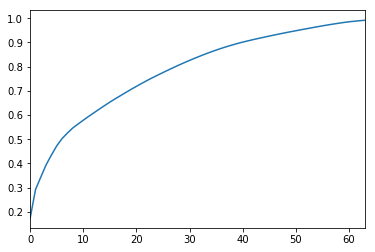

In [10]:
import time
from sklearn.decomposition import PCA
# Apply PCA to data to reduce dimensions
# Find best pca_dim
# PCA Fit and Transformation and DF Reconstruction
def pca_transform_reconstruct(fit_data, trans_data, pca_dim):
    start_time = time.time()
    
    pca = PCA(n_components=pca_dim)
    pca.fit(fit_data)

    data_pca = pca.transform(trans_data)
    data_pca = pd.DataFrame(data=data_pca)

    cp_imp = pca.explained_variance_ratio_
    cp_imp = pd.Series(cp_imp)
    cp_imp_cum = cp_imp.cumsum()
    cp_imp_cum.plot()
    print(cp_imp_cum.iloc[-1])
    print("Fitting PCA took {} seconds".format(time.time() - start_time))

    return data_pca

X_train_pca = pca_transform_reconstruct(X_train, X_train, 64)

In [11]:
X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,-0.353087,-0.943307,-0.454454,0.009154,-0.104295,-0.655841,-0.454114,0.253631,-0.697426,-0.243044,-0.016496,-0.105535,-0.139537,-0.062911,-0.009733,0.282499,0.227236,-0.402585,0.527189,0.165919,-0.228169,-0.389138,-0.143539,-0.185168,0.424412,0.614983,0.001621,-0.147635,-0.324217,-0.308485,-0.258809,-0.110809,-0.046949,-0.069104,-0.063252,0.004274,-0.097030,-0.058680,0.082513,-0.018743,0.110940,-0.028138,-0.079113,0.116604,-0.018338,-0.059717,-0.007809,0.001427,-0.018442,-0.003729,-0.011306,-0.010659,0.003345,0.014196,0.003306,0.023323,0.021963,-0.018895,-0.008701,0.020975,-0.041944,0.011729,-0.074743,0.021333
1,-0.523470,-0.662266,-0.480834,-0.064430,-0.104046,-0.664467,0.155908,-0.822660,-0.184944,0.026919,-0.000203,0.096163,-0.240539,-0.109926,-0.138693,0.257540,0.274116,-0.443630,0.620443,0.146369,-0.206833,-0.366137,-0.115978,-0.187744,0.417360,0.593779,-0.011993,-0.127478,-0.324807,-0.280778,-0.263471,-0.110282,-0.036970,-0.084479,-0.061598,0.015010,-0.076704,-0.071251,0.077813,-0.026478,0.096902,-0.008194,0.111984,0.017557,-0.003822,-0.084346,0.019042,-0.007840,-0.015561,0.003986,-0.017466,-0.012575,0.016691,0.013815,-0.011951,0.040254,0.029623,-0.027357,-0.018991,-0.005055,0.000147,0.002530,-0.019828,0.008147
2,-0.567085,-0.679064,-0.490208,-0.165925,-0.222793,0.489316,-0.708098,-0.481752,-0.188386,-0.020754,0.014743,0.057648,-0.254656,-0.118336,-0.178543,0.233549,0.255358,-0.452053,0.606729,0.139954,-0.195934,-0.363934,-0.098402,-0.176613,0.418344,0.599037,-0.024534,-0.159933,-0.320508,-0.278536,-0.281387,-0.118405,-0.028885,-0.069438,-0.077628,0.015126,-0.075917,-0.072159,0.079653,-0.032202,0.092477,-0.011208,0.098376,0.020184,-0.006650,-0.083523,0.023299,-0.005256,-0.017787,0.002320,-0.024036,-0.014990,0.010260,0.005056,-0.013402,0.040442,0.029477,-0.027537,-0.019415,-0.002074,0.009776,-0.009135,0.015890,-0.000505
3,1.257606,0.279324,-0.539552,0.042394,-0.205093,-0.038173,-0.066665,-0.125302,-0.127524,-0.497728,0.015152,-0.072106,-0.169338,-0.135038,-0.094016,0.319441,0.525680,0.284441,1.108597,0.342095,-0.053052,-0.009031,-0.062168,-0.149312,0.320750,0.673396,0.020214,-0.127476,-0.326782,-0.337543,-0.305557,-0.207332,-0.062774,-0.090171,-0.054560,0.003577,-0.047190,-0.143041,0.074708,-0.009120,0.107582,-0.009810,0.002893,0.076243,-0.011281,-0.060323,-0.005111,0.002899,-0.037866,0.004694,-0.010180,-0.015352,0.004676,0.005709,-0.005445,0.030902,0.015694,-0.017837,-0.007390,0.005577,0.030149,-0.018567,0.013918,-0.101567
4,-0.360261,-0.920386,-0.458612,0.013902,-0.106202,-0.657726,-0.444801,0.396783,-0.331658,-0.237168,0.014168,-0.011112,0.034825,0.026713,0.109943,0.425618,0.205074,-0.383419,0.542984,0.152884,-0.210851,-0.414590,-0.146666,-0.192423,0.416423,0.614587,-0.004256,-0.167297,-0.321465,-0.301112,-0.236014,-0.114192,-0.051038,-0.069499,-0.067712,0.001617,-0.077899,-0.071589,0.091010,-0.014746,0.108228,-0.032645,-0.082547,0.115144,-0.020700,-0.055288,-0.002478,0.003942,-0.020214,-0.003327,-0.012126,-0.008624,0.004143,0.018531,0.003320,0.022887,0.024921,-0.014855,-0.010506,0.017350,-0.044583,0.017637,-0.082356,0.022227


In [12]:
# from sklearn.linear_model import RandomizedLasso

# names = list(X_train_pca.columns)

# rlasso = RandomizedLasso(alpha='aic')
# rlasso.fit(X_train_pca, y_train)
# rlasso_ranking = sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), names), reverse=True)
# print("Features sorted by their score:")
# print(rlasso_ranking)

In [13]:
# 10 features before the drop
# plt.plot([x[0] for i, x in enumerate(rlasso_ranking)])

In [14]:
# X_validation = X_train.loc[validation_data_index, :]
# X_test = X_train.loc[test_data_index, :]

# print(X_validation.shape)
# print(X_test.shape)

In [15]:
# print(X_train)

In [16]:
# print(validation_data_index[:10])

In [17]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# def train_predict(X_train, y_train, val_data_index):
#     start_time = time.time()

#     pred_y_list = []
#     counter = 0
#     for i in val_data_index:
#         X_batch = X_train.loc[:i-1, :]
#         y_batch = y_train.loc[:i-1]

#         clf = RandomForestClassifier(n_estimators=256, n_jobs=-1, random_state=42)
#         clf.fit(X_batch, y_batch)

#         X_val = X_train.loc[i, :].values.reshape(1, -1)

#         pred_y = clf.predict(X_val)
#         pred_y_list.append(pred_y)
        
#         counter += 1
#         print('Predicting ' + str(counter) + 'th row.')
#         print(accuracy_score(y_train[validation_data_index][:counter], pred_y_list))
#     print("Training took {} seconds.".format(time.time() - start_time))
    
#     return pred_y_list

In [18]:
# pred_y_list = train_predict(X_train, y_train, validation_data_index)

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_pca, y_train, test_size=0.33, random_state=13)

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import log_loss

start_time = time.time()

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

svr = svm.SVC(probability=True)
clf = GridSearchCV(svr, parameters, scoring='neg_log_loss', n_jobs=-1, cv=9)
clf.fit(X_train, y_train)

print("Training took {} seconds".format(time.time() - start_time))

KeyboardInterrupt: 

In [21]:
print(clf.best_score_)
print(clf.best_params_)

-0.667167296059
{'C': 10, 'kernel': 'rbf'}


In [23]:
from sklearn.metrics import accuracy_score

pred = clf.predict(X_test)
print(accuracy_score(y_test, pred))

0.620917344653


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

start_time = time.time()

parameters = {'n_estimators':(256, 512, 1024, 2048), 'criterion':('gini', 'entropy'), 'min_samples_leaf': (10, 50, 100, 500)}

rf = RandomForestClassifier(n_jobs=-1, random_state=13)
rf_grd = GridSearchCV(rf, parameters, scoring='neg_log_loss', n_jobs=-1, cv=9)
rf_grd.fit(X_train, y_train)

print(rf_grd.best_score_)
print(rf_grd.best_params_)

print("Training took {} seconds".format(time.time() - start_time))

-0.655407812522
{'criterion': 'entropy', 'n_estimators': 1024, 'min_samples_leaf': 100}
Training took 25409.826553821564 seconds


In [21]:
pred = rf_grd.predict(X_test)
print(accuracy_score(y_test, pred))

0.618559132178
